In [1]:
import xarray as xr
from glob import glob
import sys
import pandas as pd
import otps
import os
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from cmocean import cm

import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS

def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim='time'):
    
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have 
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept, 
    p-value, and standard error on regression between the two datasets along their aligned first dimension.  
    
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    
    Parameters
    ----------    
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy 
        shifting y with the specified lag amount. 
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on 
        regression between the two datasets along their aligned first dimension.  

    """ 
    
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        
        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr 
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)
        
        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x,y = xr.align(x, y)

    if lagy!=0:
        
        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    #4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)
    
    #5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    #6. Compute regression slope and intercept:
    slope = cov / (xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


def date_range(start_date, end_date, increment, period):
    
    """Generate dates seperated by given time increment/period"""
    
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result


# Extract vertex coordinates and heights from geopandas
def contours_to_arrays(gdf, col):

    coords_zvals = []

    for i in range(1, len(gdf)):

        val = gdf.iloc[i][col]

        try:
            coords = np.concatenate([np.vstack(x.coords.xy).T for x in gdf.iloc[i].geometry])

        except:
            coords = np.vstack(gdf.iloc[i].geometry.coords.xy).T

        coords_zvals.append(np.column_stack((coords, np.full(np.shape(coords)[0], fill_value=val))))

    return np.concatenate(coords_zvals)


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling, SpatialTools, DEAPlotting, BandIndices

%load_ext autoreload
%autoreload 2

## Set up analysis

In [2]:
# Set coords
# lat, lon, study_area = -14.797361, 128.466634, "cambridge"  
# lat, lon, study_area = -24.75, 152.353044, "burnett" 
# lat, lon, study_area = -15.19733, 141.59417, 'mitchell'
# lat, lon, study_area = -15.9448, 124.1996, 'doubtfulbay'
# lat, lon, study_area = -19.65948, 147.57290, 'burdekin'
lat, lon, study_area =-16.7410731923,  122.775502322, 'penderbay'
time_range = ('1986-06-01', '2018-12-31')

# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Set up analysis data query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 5800, x + 5800),
         'y': (y - 5000, y + 5500),         
         'crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'output_crs': 'EPSG:3577',
         'time': time_range}

DEAPlotting.display_map(x=query['x'], y=query['y'])

## Load data

In [3]:
# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir'], # 'swir1', 'swir2'], 
                                       masked_prop=0.5, mask_pixel_quality=True) 

# Compute water indices
data['NDWI'] = BandIndices.calculate_indices(data, 'NDWI')
# data['MNDWI'] = BandIndices.calculate_indices(data, 'MNDWI')
# data['WI'] = BandIndices.calculate_indices(data, 'WI')
# data['AWEI_noshadow'] = BandIndices.calculate_indices(data, 'AWEI_noshadow')
# data['AWEI_shadow'] = BandIndices.calculate_indices(data, 'AWEI_shadow')

data = data.astype(np.float32)
data.NDWI.isel(time = 5).plot(size=10)
                                                        

Loading ls5 pixel quality
Loading ls5 pixel quality
    Skipping ls5; no valid data for query
Loading ls7 pixel quality
    Skipping ls7; no valid data for query
Loading ls8 pixel quality
    Skipping ls8; no valid data for query
Combining and sorting  data


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/combine.py", line 87, in concat
    first_obj, objs = utils.peek_at(objs)
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/utils.py", line 133, in peek_at
    peek = next(gen)
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-83cb2c089104>", line 4, in <module>
    masked_prop=0.5, mask_pixel_quality=True)
  File "../10_Scripts/DEADataHandling.py", line 397, in load_clearlandsat
    combined_ds = xr.concat(filtered_sensors, dim='time')
  File "/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/combine.py",

TypeError: must be str, not list

## Compute tides

In [7]:
# Calculate old tide heights
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
observed_timepoints = [otps.TimePoint(lon, lat, dt) for dt in observed_datetimes]
observed_predictedtides = otps.predict_tide(observed_timepoints)
tideheights_old = [predictedtide.tide_m for predictedtide in observed_predictedtides]
data['tideheights_old'] = xr.DataArray(tideheights_old, [('time', data.time)])


## Rolling NIDEM

In [7]:
# time_period = ('1987-01-01', '2018-01-01')
# epoch_years = 10

# # Create list of epochs between start and end of time_period in datetime format
# start = datetime.strptime(time_period[0], '%Y-%m-%d')
# end = datetime.strptime(time_period[1], '%Y-%m-%d')
# epochs = date_range(start, end, epoch_years, 'years')

# # Print list of epochs
# epochs_strings = [epoch.strftime('%Y-%m-%d') for epoch in epochs][:-1]
# print('Processing {} epochs: {}'.format(len(epochs_strings), ', '.join(epochs_strings)))


time_period = ('1987-01-01', '2009-01-01')
epoch_years = 10
epochs = pd.date_range(start=time_period[0], end=time_period[1],  freq='AS')
epochs



DatetimeIndex(['1987-01-01', '1988-01-01', '1989-01-01', '1990-01-01',
               '1991-01-01', '1992-01-01', '1993-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

### Interpolation

In [9]:
# If output data directory doesn't exist, create it
if not os.path.isdir(f'output_data/rolling_outputs/{study_area}/'):
    os.makedirs(f'output_data/rolling_outputs/{study_area}/')
    os.makedirs(f'output_data/rolling_outputs/{study_area}/contours/')
    os.makedirs(f'output_data/rolling_outputs/{study_area}/dem/')
    os.makedirs(f'output_data/rolling_outputs/{study_area}/diff/')
    os.makedirs(f'output_data/rolling_outputs/{study_area}/mask/')
    os.makedirs(f'output_data/rolling_outputs/{study_area}/rgb/')
    
# Create output dict
dem_dict = {}
intertidal_mask_dict = {}

for epoch in epochs[:-1]:
    
    # Identify from and to date strings
    from_date = epoch.strftime('%Y-%m-%d')
    to_date = (epoch + relativedelta(years=epoch_years)).strftime('%Y-%m-%d')    
    print(from_date, to_date)   
    

    ###################
    # Convert to tide #
    ###################    

    data_tidal = data.sel(time=slice(from_date, to_date)).swap_dims({'time': 'tideheights_old'}).sortby('tideheights_old')
#     data_tidal = data_tidal[['NDWI', 'MNDWI', 'WI', 'AWEI_noshadow', 'AWEI_shadow', 'red', 'green', 'blue']]
    data_tidal = data_tidal[['NDWI', 'red', 'green', 'blue']]
    data_tidal['tideheights_var'] = data_tidal.tideheights_old

    data_tidal = data_tidal.rolling(tideheights_old = 50, center=True, min_periods=1).median(dim='tideheights_old')
    data_tidal = data_tidal.astype(np.float32)

    # Copy rolling median tide heights back into dimension
    data_tidal['tideheights_old'] = data_tidal['tideheights_var']

    
    ####################
    # Extract contours #
    ####################

    custom_attrs = {'elev_m': data_tidal['tideheights_var'].values.astype(np.float64)}
    custom_attrs_dtypes = {'elev_m': 'float:9.2'}

    nidem_rolling_df = SpatialTools.contour_extract(z_values=0.0,
                                 ds_array=data_tidal.NDWI,
                                 ds_crs=data.geobox.crs,
                                 ds_affine=data.geobox.affine,
                                 output_shp=f'output_data/rolling_outputs/{study_area}/contours/contours_{study_area}_{from_date[0:4]}_{to_date[0:4]}.shp',
                                 dim='tideheights_old',
                                 attribute_data=custom_attrs,
                                 attribute_dtypes=custom_attrs_dtypes,
                                 verbose=False)

    ###############
    # Interpolate #
    ###############

    # Extract x, y and z points for interpolation
    all_contours = contours_to_arrays(gdf=nidem_rolling_df, col='elev_m')
    points_xy = all_contours[:, [1, 0]]
    values_elev = all_contours[:, 2]

    # # Create grid to interpolate into
    x_size, _, upleft_x, _, y_size, upleft_y =  data.geobox.transform[0:6]
    xcols = len(data.x)
    yrows = len(data.y)
    bottomright_x = upleft_x + (x_size * xcols)
    bottomright_y = upleft_y + (y_size * yrows)
    grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * yrows, upleft_x:bottomright_x:1j * xcols]

    # # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

    # # Apply guassian blur to smooth transitions between z values (optional)
    # from skimage import filters
    # out = filters.gaussian(out, sigma=2)   

    ##########
    # Export #
    ##########

    # Remove water in lowest tide, and land in highest tide 
    # todo: replace with removing any pixel always water, always land
    intertidal_mask = np.where(data_tidal.isel(tideheights_old = 0).NDWI > 0, 1, 
                               np.where(data_tidal.isel(tideheights_old = -1).NDWI < 0, 2, 0))
    out_masked = np.where(intertidal_mask > 0, -9999, out)
    
    # Append to dict
    dem_dict[f'{from_date[0:4]}_{to_date[0:4]}'] = out_masked
    intertidal_mask_dict[f'{from_date[0:4]}_{to_date[0:4]}'] = intertidal_mask

    # Export raw DEM
    import rasterio
    kwargs = {'driver': 'GTiff',
             'width': xcols,
             'height': yrows,
             'count': 1,
             'dtype': rasterio.float64,
             'crs': 'EPSG:3577',
             'transform': data.geobox.transform,
             'nodata': -9999}

    with rasterio.open(f'output_data/rolling_outputs/{study_area}/dem/dem_{study_area}_{from_date[0:4]}_{to_date[0:4]}.tif', 'w', **kwargs) as target:
        target.write_band(1, out_masked)
    
    # Export intertidal mask
    kwargs = {'driver': 'GTiff',
             'width': xcols,
             'height': yrows,
             'count': 1,
             'dtype': rasterio.int16,
             'crs': 'EPSG:3577',
             'transform': data.geobox.transform,
             'nodata': -9999}

    with rasterio.open(f'output_data/rolling_outputs/{study_area}/mask/intertidal_{study_area}_{from_date[0:4]}_{to_date[0:4]}.tif', 'w', **kwargs) as target:
        target.write_band(1, intertidal_mask.astype(rasterio.int16))
        
        
    #############
    # Geomedian #
    #############
    
    geomedian_layer = data_tidal[['red', 'green', 'blue']].sel(tideheights_old = data_tidal.tideheights_var < 0.0).median(dim='tideheights_old')

    kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 3,
         'dtype': rasterio.float32,
         'crs': 'EPSG:3577',
         'transform': data.geobox.transform,
         'nodata': -9999}

    with rasterio.open(f'output_data/rolling_outputs/{study_area}/rgb/rgb_{study_area}_{from_date[0:4]}_{to_date[0:4]}.tif', 'w', **kwargs) as target:
        target.write(geomedian_layer.to_array().values)
        


1987-01-01 1997-01-01
Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/rolling_outputs/penderbay/contours/contours_penderbay_1987_1997.shp
1988-01-01 1998-01-01
Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/rolling_outputs/penderbay/contours/contours_penderbay_1988_1998.shp
1989-01-01 1999-01-01
Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/rolling_outputs/penderbay/contours/contours_penderbay_1989_1999.shp
1990-01-01 2000-01-01
Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/rolling_outputs/penderbay/contours/contours_penderbay_1990_2000.shp
1991-01-01 2001-01-01
Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/rolling_outputs/penderbay/contours/contours_penderbay_1991_2001.shp
1992-01-01 2002-01-01
Operating in single z-value, multiple arrays mode
Exporting con

In [117]:
# # Extract x, y and z points for interpolation
# all_contours = contours_to_arrays(gdf=nidem_rolling_df, col='elev_m')
# points_yx = all_contours[:, [1, 0]]
# values_elev = all_contours[:, 2]


def interpolate_grid(coords=all_contours[:, [1, 0]], z_values=all_contours[:, 2], method='linear',
                     resolution=10, geotransform=data.geobox.transform, shape=(len(data.y), len(data.x))):
    
    # Compute 
    x_size, _, upleft_x, _, y_size, upleft_y =  geotransform[0:6]
    west, south, east, north = rasterio.transform.array_bounds(height=shape[0], 
                                                               width=shape[1], 
                                                               transform=data.geobox.transform)

    # Compute number of output x and y cells based on extent and output resolution
    width = int((east - west) / resolution)
    height = int((north - south) / resolution)

    # Create meshgrid and interpolate new values for every pixel 
    grid_y, grid_x = np.mgrid[north:south:1j * height, west:east:1j * width]
    out = scipy.interpolate.griddata(coords, z_values, (grid_y, grid_x), method=method)

    # Compute new geotransform based on 
    new_east = west + (resolution * width)
    new_south = north - (resolution * height)
    print(north, south)
    print(new_south)
    new_geotransform = rasterio.transform.from_bounds(west=west, south=new_south, east=new_east, north=north, 
                                                      width=width, height=height)
    
    return out, new_geotransform

out, geotransform = interpolate_grid()


  # Export raw DEM
import rasterio
kwargs = {'driver': 'GTiff',
         'width': out.shape[1],
         'height': out.shape[0],
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:3577',
         'transform': geotransform,
         'nodata': -9999}

with rasterio.open(f'output_data/rolling_outputs/{study_area}/dem/test_highres.tif', 'w', **kwargs) as target:
    target.write_band(1, out)










-1813200.0 -1823725.0
-1823720.0


In [10]:
min_tide = np.nanmin([np.where(i != -9999, i, np.nan) for i in dem_dict.values()])
max_tide = np.nanmax([np.where(i != -9999, i, np.nan) for i in dem_dict.values()])
tide_fills = [np.array([0, min_tide, max_tide])[i] for i in intertidal_mask_dict.values()]
timesteps = {key:np.where(tide_fills[i] == 0, val, tide_fills[i]) for i, (key, val) in enumerate(dem_dict.items())}

import rasterio
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:3577',
         'transform': data.geobox.transform,
         'nodata': -9999}

total_lossgain_list = []

for i, (key, timestep) in enumerate(timesteps.items()):
    
    try:
        
        next_key = list(timesteps.keys())[i+1]
        print(f'{next_key} minus {key}')

        with rasterio.open(f'output_data/rolling_outputs/{study_area}/diff/diff_cm_{study_area}_{next_key}_minus_{key}.tif', 'w', **kwargs) as target:
            target.write_band(1, timesteps[next_key] - timestep)
            
        with rasterio.open(f'output_data/rolling_outputs/{study_area}/diff/diff_m3_{study_area}_{next_key}_minus_{key}.tif', 'w', **kwargs) as target:
            target.write_band(1, (timesteps[next_key] - timestep) * (25.0 * 25.0))
        
        # Compute total gain or loss in metres^3
        total_lossgain = np.nansum((timesteps[next_key] - timestep) * (25.0 * 25.0))
        total_lossgain_list.append((key, total_lossgain))
    
    except:
        pass  

# Export last minus first
with rasterio.open(f'output_data/rolling_outputs/{study_area}/diff/diff_m3_{study_area}_last_minus_first.tif', 'w', **kwargs) as target:
    target.write_band(1, (timesteps[list(timesteps.keys())[-1]] - timesteps[list(timesteps.keys())[0]]) * (25.0 * 25.0)) 

1988_1998 minus 1987_1997
1989_1999 minus 1988_1998
1990_2000 minus 1989_1999
1991_2001 minus 1990_2000
1992_2002 minus 1991_2001
1993_2003 minus 1992_2002
1994_2004 minus 1993_2003
1995_2005 minus 1994_2004
1996_2006 minus 1995_2005
1997_2007 minus 1996_2006
1998_2008 minus 1997_2007
1999_2009 minus 1998_2008
2000_2010 minus 1999_2009
2001_2011 minus 2000_2010
2002_2012 minus 2001_2011
2003_2013 minus 2002_2012
2004_2014 minus 2003_2013
2005_2015 minus 2004_2014
2006_2016 minus 2005_2015
2007_2017 minus 2006_2016
2008_2018 minus 2007_2017


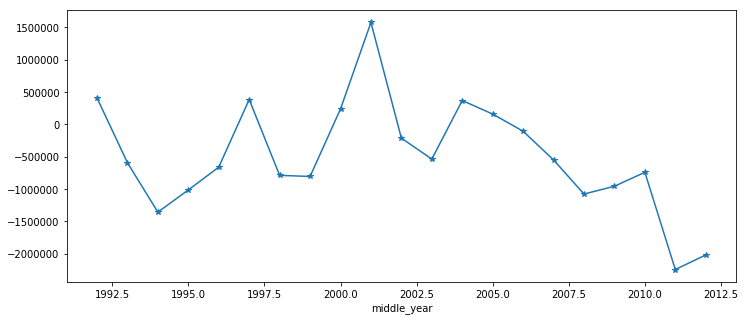

In [15]:
flux_df = pd.DataFrame(total_lossgain_list, columns=['period', 'flux_m3'])
flux_df['from_year'], flux_df['to_year'] = flux_df.period.str.split('_').str
flux_df['from_year'] = flux_df['from_year'].astype(int)
flux_df['to_year'] = flux_df['to_year'].astype(int)
flux_df['middle_year'] = (flux_df['from_year'] + flux_df['to_year']) / 2.0
flux_df.set_index('middle_year').flux_m3.plot(figsize=(12,5), marker='*')



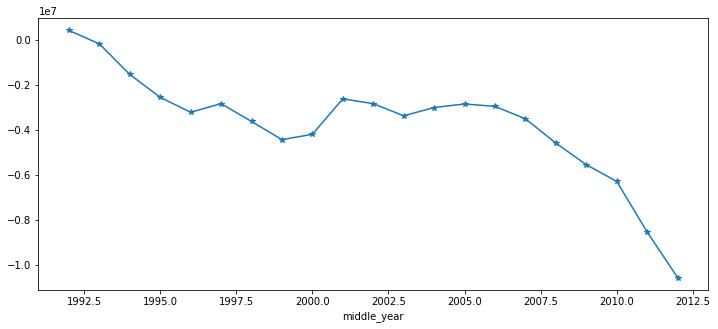

In [16]:
flux_df.set_index('middle_year').flux_m3.cumsum().plot(figsize=(12,5), marker='*')

## Test animation

Generating 22 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to output_data/rolling_outputs/penderbay/dem_animation.gif


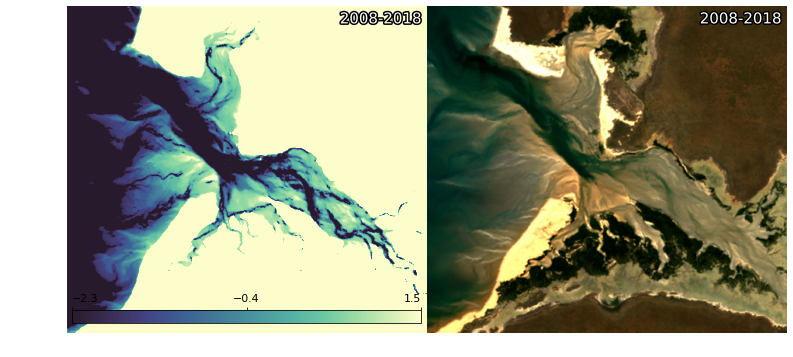

In [8]:
import xarray as xr
import glob

def time_index_from_filenames(filenames, string_slice=slice(0, 10)):
    '''
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string
    '''
    
    date_strings = [os.path.basename(i)[string_slice] for i in filenames]
    
    return pd.to_datetime(date_strings)

###############
# Import DEMs #
###############

# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob(f"output_data/rolling_outputs/{study_area}/dem/dem_*tif"))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(-13, -9)))
yrows, xcols= 421, 465
chunks = {'x': yrows, 'y': xcols, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_ds = concat_arrays.to_dataset(dim='band')
concat_ds = concat_ds.rename({1: 'dem'})
concat_ds = concat_ds.sortby('time')
concat_ds = concat_ds.where(concat_ds.dem != -9999.)

################
# Import masks #
################

# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob(f"output_data/rolling_outputs/{study_area}/mask/intertidal_*tif"))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(-13, -9)))
chunks = {'x': yrows, 'y': xcols, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_masks = concat_arrays.to_dataset(dim='band')
concat_masks = concat_masks.rename({1: 'mask'})
concat_masks = concat_masks.sortby('time')
# concat_masks = concat_masks.compute()

min_tide = concat_ds.dem.min().compute().item()
max_tide = concat_ds.dem.max().compute().item()
concat_ds = concat_ds.where(concat_masks.mask != 1, other=min_tide)
concat_ds = concat_ds.where(concat_masks.mask != 2, other=max_tide)


##############
# Import RGB #
##############

# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob(f"output_data/rolling_outputs/{study_area}/rgb/rgb_*tif"))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(-13, -9)))
chunks = {'x': yrows, 'y': xcols, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_rgb = concat_arrays.to_dataset(dim='band')
concat_rgb = concat_rgb.rename({1: 'red', 2: 'green', 3: 'blue'})
concat_rgb = concat_rgb.sortby('time')


###########
# Animate #
###########

DEAPlotting.animated_doubletimeseries(ds1=concat_ds.fillna(0).isel(x=slice(0, -1)).compute(), 
                                      ds2=concat_rgb.isel(x=slice(0, -1)).compute(),
                                      output_path=f'output_data/rolling_outputs/{study_area}/dem_animation.gif',
                                      bands1=['dem'], 
                                      interval=70, width_pixels=1200,
                                      percentile_stretch2=[0.03, 0.97],
                                      onebandplot_kwargs1=dict(cmap = cm.deep_r, vmin=-2.3, vmax=1.5),
                                      show_date1=False, show_date2=False,
                                      title1=[f'{i.item()}-{i.item() + epoch_years}' for i in concat_ds.time.dt.year],                                                                     
                                      title2=[f'{i.item()}-{i.item() + epoch_years}' for i in concat_ds.time.dt.year])


In [46]:
import glob
import rasterio
import numpy as np
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from unsharp_mask import unsharp_mask

# Export raw DEM
import rasterio
kwargs = {'driver': 'GTiff',
         'width': xcols,
         'height': yrows,
         'count': 1,
         'dtype': rasterio.float64,
         'crs': 'EPSG:3577',
         'transform': concat_ds.transform,
         'nodata': -9999}

rgb_kwargs = {'driver': 'GTiff',
     'width': xcols,
     'height': yrows,
     'count': 3,
     'dtype': rasterio.int16,
     'crs': 'EPSG:3577',
     'transform': concat_ds.transform,
     'nodata': -9999}

for i in range(0, len(concat_ds.time)):   
    
    name = concat_ds.isel(time=i).time.dt.year.item()

    with rasterio.open(f'output_data/rolling_outputs/{study_area}/anim_{study_area}_{name}.tif', 'w', **kwargs) as target:
        target.write_band(1, concat_ds.isel(time=i).dem.fillna(-9999).values)
        
    hltc_array = concat_rgb.isel(time=i).to_array().compute().values
    p_low, p_high = np.nanpercentile(hltc_array, [0.5, 99.5])
    hltc_array = exposure.rescale_intensity(hltc_array, in_range=(p_low, p_high), out_range=(0, 1))
    hltc_array = np.transpose(hltc_array, (1, 2, 0))

    # Fix dtype and extract only first three bands
    hltc_array = (hltc_array * 10000).astype(rasterio.int16)
    hltc_array = np.transpose(hltc_array, (2, 0, 1))  

    with rasterio.open(f'output_data/rolling_outputs/{study_area}/rgb_{study_area}_{name}.tif', 'w', **rgb_kwargs) as target:
        target.write(hltc_array)


    

In [44]:

# with rasterio.open() as file:
    
#     hltc_array = file.read([3, 2, 1])
#     hltc_profile = file.profile    
    
#     hltc_array[hltc_array == -999.0] = np.nan
#     p_low, p_high = np.nanpercentile(hltc_array, [0.5, 99.5])
#     hltc_array = exposure.rescale_intensity(hltc_array, in_range=(p_low, p_high), out_range=(0, 1))
#     hltc_array = hsv_image_processing(np.transpose(hltc_array, (1, 2, 0)))
    
#     # Fix dtype and extract only first three bands
#     hltc_array = (hltc_array * 10000).astype(rasterio.int16)
#     hltc_array = np.transpose(hltc_array, (2, 0, 1))  



In [ ]:
# from datacube.helpers import write_geotiff
# from skimage.filters import threshold_otsu

# test = dict(NDWI=data_tidal.isel(tideheights_old=0)['NDWI'],
#             MNDWI=data_tidal.isel(tideheights_old=0)['MNDWI'],
#             AWEI_shadow=data_tidal.isel(tideheights_old=0)['AWEI_shadow'],
#             AWEI_noshadow=data_tidal.isel(tideheights_old=0)['AWEI_noshadow'],
#             WI=data_tidal.isel(tideheights_old=0)['WI'],
#            )

# # Plot RGB
# rgb = data_tidal.isel(tideheights_old=0)[['red','green', 'blue']]
# rgb.attrs['affine'] = data.affine
# rgb.attrs['crs'] = data.crs
# write_geotiff(f'output_data/indextest_rgb.tif', rgb)

# # Export other indices
# for key, to_write in test.items():
#     otsu = threshold_otsu(to_write.values[np.isfinite((to_write > 0).values)])
#     print(key, otsu)
#     to_write = to_write.to_dataset()
#     to_write.attrs['affine'] = data.affine
#     to_write.attrs['crs'] = data.crs
#     write_geotiff(f'output_data/indextest_{key}.tif', to_write, profile_override={'nodata': -9999})
#     write_geotiff(f'output_data/indextest_{key}_classified.tif', (to_write > 0).astype(np.int32), profile_override={'nodata': -9999})
#     write_geotiff(f'output_data/indextest_{key}_otsu.tif', (to_write > otsu).astype(np.int32), profile_override={'nodata': -9999})
    

In [ ]:
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

In [ ]:
Rbf(y=all_contours[:, 1], x=all_contours[:, 0], z=all_contours[:, 2], epsilon=2)



# points_xy = all_contours[:, [1, 0]]
# values_elev = all_contours[:, 2]

In [ ]:
z

## Testing confidence

In [ ]:
data_tidal.mean(dim='tideheights_old').NDWI.plot(size=10)

In [ ]:
DEAPlotting.rgb(data_tidal.isel(x=slice(300, 500), y=slice(0, 200), tideheights_old=0), aspect=1)

In [ ]:
y, x = -1572144.852608, -378147.238835
data_tidal.sel(y=y, x=x, method='nearest').NDWI.plot()
# .rolling(tideheights_old = 50, center=True, min_periods=1).median(dim='tideheights_old')

In [ ]:
test = data_tidal.sel(y=y, x=x, method='nearest').rolling(tideheights_old = 50, center=True, min_periods=1).median(dim='tideheights_old')
test.sel(tideheights_old = (test.NDWI > -0.4) & (test.NDWI < 0.4))[['NDWI', 'tideheights_var']].to_dataframe().corr(method='spearman').iloc[0, 1]


# cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=data_tidal.tideheights_var, 
#                   y=data_tidal.NDWI, lagx=0, lagy=0, first_dim='tideheights_old')

In [ ]:
test.sel(tideheights_old = (test.NDWI > -0.4) & (test.NDWI < 0.4)).tideheights_var

In [ ]:
import scipy

scipy.stats.spearmanr(data_tidal.sel(x=slice(x- 500, x + 500), y=slice(y + 500, y - 500)).NDWI.values, 
                      ((data_tidal.sel(x=slice(x- 500, x + 500), y=slice(y + 500, y - 500)).NDWI.values / data_tidal.sel(x=slice(x- 500, x + 500), y=slice(y + 500, y - 500)).NDWI.values) * data_tidal.tideheights_var.values.reshape((490, 1, 1))), axis=0)

In [ ]:
data_tidal.NDWI.values.shape

In [ ]:
((data_tidal.NDWI.values / data_tidal.NDWI.values) * data_tidal.tideheights_var.values.reshape((490, 1, 1)))

In [ ]:
np.broadcast(data_tidal.NDWI.values, data_tidal.tideheights_var.values.reshape((490, 1, 1)))

In [ ]:
np.expand_dims(data_tidal.tideheights_var.values, 2).shape

In [ ]:
data_tidal.tideheights_var.values.reshape((490, 1, 1)).shape

In [ ]:
DEAPlotting.rgb(data_tidal.sel(x=slice(x- 500, x + 500), y=slice(y + 500, y - 500), tideheights_old=slice(0.6, 1.3)), aspect=1, col='tideheights_old', col_wrap=5)
data_tidal.sel(x=slice(x- 500, x + 500), y=slice(y + 500, y - 500), tideheights_old=slice(0.6, 1.3)).NDWI.plot(col='tideheights_old', col_wrap=8)
# 

In [ ]:
data_tidal.isel(x=slice(300, 500), y=slice(0, 200), tideheights_old=300)

In [ ]:
data_tidal

In [ ]:
data_tidal.isel(x=slice(300, 500), y=slice(0, 200), tideheights_old=slice(305, 307))

In [ ]:
data_tidal['tideheights_old'] = data_tidal['tideheights_var']

## Load WA sea level into xarray format

In [ ]:
# # Open all data
# all_nodes = xr.open_mfdataset(paths=files, concat_dim='file').squeeze('coast_id')

# # Interpolate hourly results to get sea level estimates for exact acquisition time
# all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

# # Select only required timesteps
# all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

# # Re-index to give latitude, longitude and time dimensions
# test = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()


In [ ]:
# for i in range(0,len(test.time) - 1):
    
#     # Import as a dataframe with lon, lat, time, sea level columns
#     test_df_subset = test.isel(time=i).sealevel.to_dataframe().dropna(axis=0).reset_index() 

#     from pyproj import Proj, transform
#     xx, yy = transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)
#     test_df_subset['Coordinates'] = list(zip(*transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)))

#     # # Create geopandas dataframe by creating geometry column
#     # test_df_subset['Coordinates'] = list(zip(test_df_subset.longitude, test_df_subset.latitude))
#     test_df_subset['Coordinates'] = test_df_subset['Coordinates'].apply(Point)
#     test_df_subset = gpd.GeoDataFrame(test_df_subset, geometry='Coordinates', crs='EPSG:3577')
#     # # # test_gdf.to_file('test.shp')

#     # Interpolate
#     resolution = 500
#     out = interp_tides(x_coords=test_df_subset['longitude'].values, 
#                        y_coords=test_df_subset['latitude'].values, 
#                        z_coords=test_df_subset[['sealevel']].values, 
#                        sigma=15, resolution=resolution)


#     # Create land sea mask from shapefile
#     test_affine = rasterio.transform.from_bounds(west=xx.min(), 
#                                                  south=yy.min(), 
#                                                  east=xx.max(), 
#                                                  north=yy.max(), width=out.shape[1], height=out.shape[0])

#     coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
#                                                      out_shape=(resolution, resolution),
#                                                      transform=test_affine,
#                                                      all_touched=False, invert=True)
    
#     print(np.min(out), np.max(out))

#     # Remove land
#     out[coastline_mask] = np.nan
# #     out[out > 2500] = np.nan
# #     out[out < 1500] = np.nan

#     # Plot
#     fig, ax = plt.subplots(1, 2, figsize=(20, 16))
#     test_df_subset.plot(column='sealevel', ax=ax[0])
#     im = ax[1].imshow(out, extent=[upleft_x, bottomright_x, bottomright_y, upleft_y], vmin=-2000, vmax=3000)
#     # fig.colorbar(im)



In [111]:
# Set up spatial and temporal query
query = {'x': (954163, 972163),
         'y': (-3573891, -3555891),
         'time': ('2011-06-01', '2013-06-01'),
         'crs': 'EPSG:3577'}   

# Load observations with less than 25% cloud from ls5, ls7 and ls8 as a single combined dataset
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5'], 
                                   bands_of_interest=['red', 'green', 'blue'], 
                                   masked_prop=0.75, mask_pixel_quality=True, ls7_slc_off=True)


Loading ls5
    Loading 4 filtered ls5 timesteps
Combining and sorting ls5 data


In [105]:
landsat_ds

<xarray.Dataset>
Dimensions:    (time: 36, x: 721, y: 721)
Coordinates:
  * y          (y) float64 -3.556e+06 -3.556e+06 ... -3.574e+06 -3.574e+06
  * x          (x) float64 9.542e+05 9.542e+05 9.542e+05 ... 9.721e+05 9.722e+05
  * time       (time) datetime64[ns] 2011-06-12T00:13:59.500000 ... 2013-05-16T00:16:16
Data variables:
    red        (time, y, x) float64 1.397e+03 1.244e+03 ... 1.193e+03 1.085e+03
    green      (time, y, x) float64 861.0 816.0 772.0 ... 913.0 911.0 865.0
    blue       (time, y, x) float64 350.0 392.0 393.0 ... 573.0 539.0 601.0
    data_perc  (time, y, x) float64 0.8116 0.8116 0.8116 ... 0.803 0.803 0.803
Attributes:
    crs:      EPSG:3577

In [112]:
import glob
import os
import pandas as pd
import numpy as np
import datetime as dt
from otps.predict_wrapper import predict_tide
from otps import TimePoint
from pytz import timezone


def gps_week(input_datetime):
    """
    Computes GPS week number since start of GPS time epoch (6 Jan 1980).
    Currently does not account for leap seconds (only affects 10-15 second
    window around midnight Saturday night/Sunday morning each week)

    :param input_datetime: Datetime object used to identify GPS week
    :return: GPS weeks since start of GPS epoch (6 Jan 1980)
    """

    # Identify GPS week from GPS epoch using floor division
    gps_epoch = dt.datetime(1980, 1, 6)
    delta = input_datetime - gps_epoch
    gps_week_num = int(np.floor(delta.total_seconds() / 86400 / 7))

    return gps_week_num


def gps_adj_utc(gps_adj, leap_seconds=10):
    """
    Converts between adjusted GPS time and UTC, returning a datetime object.
    This assumes adjusted GPS time has already had - 1 billion subtracted from it;
    if you have unadjusted GPS time instead, subtract 1 billion before inputting
    it into this function.

    :param gps_adj: Adjusted GPS time
    :param leap_seconds: Leap seconds since start of GPS epoch; default 10
    :return: Datetime object with converted time in UTC
    """

    # Identify UTC and GPS epochs and compute offset between them
    utc_epoch = dt.datetime(1970, 1, 1)
    gps_epoch = dt.datetime(1980, 1, 6)
    utc_offset = (gps_epoch - utc_epoch).total_seconds() - leap_seconds

    # Convert to unix time then UTC by adding 1 billion + UTC offset to GPS time
    unix_timestamp = utc_offset + (int(gps_adj) + 1000000000)
    utc_time = dt.datetime.utcfromtimestamp(unix_timestamp)

    # Set UTC timezone info
    utc_time = utc_time.replace(tzinfo=timezone('UTC'))

    return utc_time


def gps_sotw_utc(gps_sotw, reference_date, leap_seconds=10):
    """
    Computes UTC time from GPS Seconds of Week format time

    :param gps_sotw: GPS seconds-of-the-week value
    :param reference_date: Date used to compute current GPS week number
    :param leap_seconds: Leap seconds since start of GPS epoch; default 10
    :return: Datetime object with converted time in UTC
    """

    # First test if GPS seconds-of-week fall within 0 and 604800 seconds
    if 0 <= int(gps_sotw) <= dt.timedelta(days=7).total_seconds():

        # Identify UTC and GPS epochs and compute offset between them
        utc_epoch = dt.datetime(1970, 1, 1)
        gps_epoch = dt.datetime(1980, 1, 6)
        utc_offset = (gps_epoch - utc_epoch).total_seconds() - leap_seconds

        # Identify GPS week
        gps_week_num = gps_week(reference_date)

        # Compute difference between UTC epoch and GPS time, then add GPS week days
        unix_timestamp = utc_offset + int(gps_sotw)
        utc_basetime = dt.datetime.utcfromtimestamp(unix_timestamp)
        utc_time = utc_basetime + dt.timedelta(days=gps_week_num * 7)

        # Set UTC timezone info
        utc_time = utc_time.replace(tzinfo=timezone('UTC'))

        return utc_time

    else:
        print("GPS seconds-of-week must be between 0 and 604800 seconds")
        return None

In [123]:
gps_sotw_utc(gps_sotw=104401.673192, reference_date=pd.to_datetime('2013-02-18'), leap_seconds=10)

datetime.datetime(2013, 2, 18, 4, 59, 51, tzinfo=<UTC>)

Timestamp('2013-02-18 00:00:00')

In [175]:
masked_prop = 0.40
miny, minx, maxy, maxx = -33.54, 148.98, -33.44, 149.03

query = {'x': (minx, maxx),
         'y': (miny, maxy),    
         'time': ('2017-06-01', '2018-06-25'),
         'crs': 'EPSG:4326',
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)}

query = {'x': (minx, maxx),
         'y': (miny, maxy),    
         'time': ('2017-06-01', '2018-06-25'),
         'crs': 'EPSG:4326',
         'output_crs': 'EPSG:4326',
         'resolution': (-0.00027, 0.00027)}

# # Lazily load Sentinel 2 data using dask
# data = dc.load(product='s2a_ard_granule',
#                measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3', 'fmask'],
#                group_by='solar_day',
#                dask_chunks={'time': 1},
#                **query)

# # Load PQ data
# # print(f'Loading {sensor} pixel quality')
# pq = dc.load(product='s2a_ard_granule',
#              measurements=['fmask'],
#              group_by='solar_day',
#              **query)

DEADataHandling.load_clearsentinel2(dc=dc, query=query, masked_prop = 0.40)

Loading s2a pixel quality
    Loading 28 filtered s2a timesteps
Loading s2b pixel quality
    Loading 36 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:       (latitude: 372, longitude: 186, time: 64)
Coordinates:
  * latitude      (latitude) float64 -33.44 -33.44 -33.44 ... -33.54 -33.54
  * longitude     (longitude) float64 149.0 149.0 149.0 ... 149.0 149.0 149.0
  * time          (time) datetime64[ns] 2017-07-02T00:12:29.027000 ... 2018-06-24T00:02:39.024000
Data variables:
    nbart_red     (time, latitude, longitude) float64 798.0 153.0 ... 530.0
    nbart_green   (time, latitude, longitude) float64 694.0 128.0 ... 476.0
    nbart_blue    (time, latitude, longitude) float64 366.0 31.0 ... 181.0 231.0
    nbart_nir_1   (time, latitude, longitude) float64 2.985e+03 ... 3.613e+03
    nbart_swir_2  (time, latitude, longitude) float64 2.491e+03 ... 1.868e+03
    nbart_swir_3  (time, latitude, longitude) float64 1.577e+03 ... 1.014e+03
    data_perc     (time) float64 0.6171 0.6047 0.5657 ... 0.5807 0.6123 0.5908
Attributes:
    crs:      EPSG:4326

In [170]:
good_quality = np.isin(pq['fmask'], test_elements=(0, 2, 3), invert=True)
good_quality = pq['fmask'].where(good_quality).notnull()

In [171]:

data_perc = good_quality.sum(dim=['x', 'y']) / (good_quality.shape[1] * good_quality.shape[2])
data_perc

<xarray.DataArray 'fmask' (time: 51)>
array([0.193627, 0.      , 0.127704, 0.708839, 0.66584 , 0.743045, 0.072966,
       0.719778, 0.049752, 0.501556, 0.018378, 0.518404, 0.762653, 0.425776,
       0.10835 , 0.304333, 0.776951, 0.289139, 0.346057, 0.18384 , 0.762908,
       0.741049, 0.001539, 0.704759, 0.765775, 0.776195, 0.      , 0.021016,
       0.770629, 0.786826, 0.716568, 0.702833, 0.091766, 0.586956, 0.741233,
       0.764254, 0.772519, 0.04474 , 0.778974, 0.437788, 0.69397 , 0.681299,
       0.771174, 0.231851, 0.699298, 0.061517, 0.591555, 0.001539, 0.13167 ,
       0.160001, 0.71226 ])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-04T00:02:21.026000 ... 2018-06-22T00:11:11.024000

<xarray.DataArray 'fmask' (time: 51)>
array([22020,     0, 14523, 80612, 75722, 84502,  8298, 81856,  5658, 57039,
        2090, 58955, 86732, 48421, 12322, 34610, 88358, 32882, 39355, 20907,
       86761, 84275,   175, 80148, 87087, 88272,     0,  2390, 87639, 89481,
       81491, 79929, 10436, 66751, 84296, 86914, 87854,  5088, 88588, 49787,
       78921, 77480, 87701, 26367, 79527,  6996, 67274,   175, 14974, 18196,
       81001])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-04T00:02:21.026000 ... 2018-06-22T00:11:11.024000

In [172]:
good_quality.sum(dim=['x', 'y'])

<xarray.DataArray 'fmask' (time: 51)>
array([22020,     0, 14523, 80612, 75722, 84502,  8298, 81856,  5658, 57039,
        2090, 58955, 86732, 48421, 12322, 34610, 88358, 32882, 39355, 20907,
       86761, 84275,   175, 80148, 87087, 88272,     0,  2390, 87639, 89481,
       81491, 79929, 10436, 66751, 84296, 86914, 87854,  5088, 88588, 49787,
       78921, 77480, 87701, 26367, 79527,  6996, 67274,   175, 14974, 18196,
       81001])
Coordinates:
  * time     (time) datetime64[ns] 2017-06-04T00:02:21.026000 ... 2018-06-22T00:11:11.024000